In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import mission_completion_query, mission_completion, _mission_completes_details
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict

In [4]:
def get_comparison_replays(g):
    return ((g.event == "Spooky Invitational" and g.guest_count == 19 and g.start_clock_seconds == 240) or \
        (g.event == 'SCL5' and ((g.venue in {"Moderne", "Library"} and g.start_clock_seconds == 270) or \
                                (g.venue in {"Veranda"}            and g.start_clock_seconds == 255))))


In [5]:
replays = get_parsed_replays(get_comparison_replays)

In [6]:
spooky_replays = [r for r in replays if 'Spooky Invitational' == r.event]

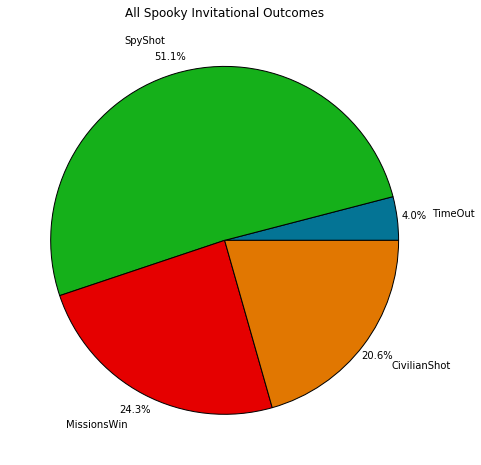

,WinType.TimeOut,WinType.SpyShot,WinType.MissionsWin,WinType.CivilianShot
NaN,11,139,66,56


In [7]:
game_outcomes(
    spooky_replays,
    axis_properties=AxisProperties(title="All Spooky Invitational Outcomes")
).frame

### Included Games (some are missing)

In [8]:
games_set = set()
for r in spooky_replays:
    games_set.add((r.division, r.week, tuple(sorted([r.spy, r.sniper]))))
sorted(games_set)

[('A', 1, ('dowsey', 'lazybear')),
 ('A', 2, ('dowsey', 'tflameee')),
 ('A', 2, ('lazybear', 'quicklime')),
 ('A', 3, ('dowsey', 'quicklime')),
 ('A', 3, ('lazybear', 'tflameee')),
 ('B', 1, ('dels', 'mrrgrs')),
 ('B', 1, ('pofke', 'yeesh')),
 ('B', 2, ('dels', 'yeesh')),
 ('B', 2, ('mrrgrs', 'pofke')),
 ('B', 3, ('dels', 'pofke')),
 ('B', 3, ('mrrgrs', 'yeesh')),
 ('Bracket', 1, ('dowsey', 'yeesh')),
 ('Bracket', 2, ('Max Edward Snax', 'dowsey')),
 ('C', 1, ('OpiWrites', 'virifaux')),
 ('C', 1, ('mintyrug', 'monopolyman')),
 ('C', 2, ('OpiWrites', 'monopolyman')),
 ('C', 2, ('mintyrug', 'virifaux')),
 ('C', 3, ('monopolyman', 'virifaux')),
 ('D', 1, ('Max Edward Snax', 'falconhit')),
 ('D', 2, ('Max Edward Snax', 'gabrio')),
 ('D', 2, ('falconhit', 'turnipboy')),
 ('D', 3, ('Max Edward Snax', 'turnipboy')),
 ('D', 3, ('falconhit', 'gabrio'))]

## Game Modes

In [9]:
def categorize_mode(r):
    return f"{r.venue} // {r.start_clock_seconds//60}:{r.start_clock_seconds%60:02d} // {r.guest_count} // {r.game_type}"

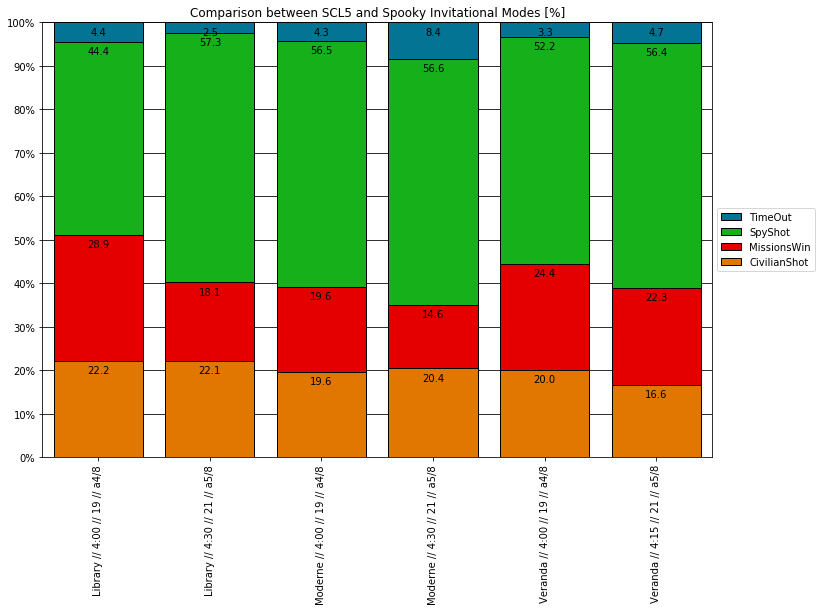

,Library // 4:00 // 19 // a4/8,Library // 4:30 // 21 // a5/8,Moderne // 4:00 // 19 // a4/8,Moderne // 4:30 // 21 // a5/8,Veranda // 4:00 // 19 // a4/8,Veranda // 4:15 // 21 // a5/8
WinType.TimeOut,0.044444,0.024742,0.043478,0.083527,0.033333,0.047393
WinType.SpyShot,0.444444,0.573196,0.565217,0.566125,0.522222,0.563981
WinType.MissionsWin,0.288889,0.181443,0.195652,0.146172,0.244444,0.222749
WinType.CivilianShot,0.222222,0.220619,0.195652,0.204176,0.200000,0.165877


In [10]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: categorize_mode(g),
        #secondary_order=sort_by_spy_wins,
        percent_normalized_data=True),
    axis_properties=AxisProperties(
        title="Comparison between SCL5 and Spooky Invitational Modes [%]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

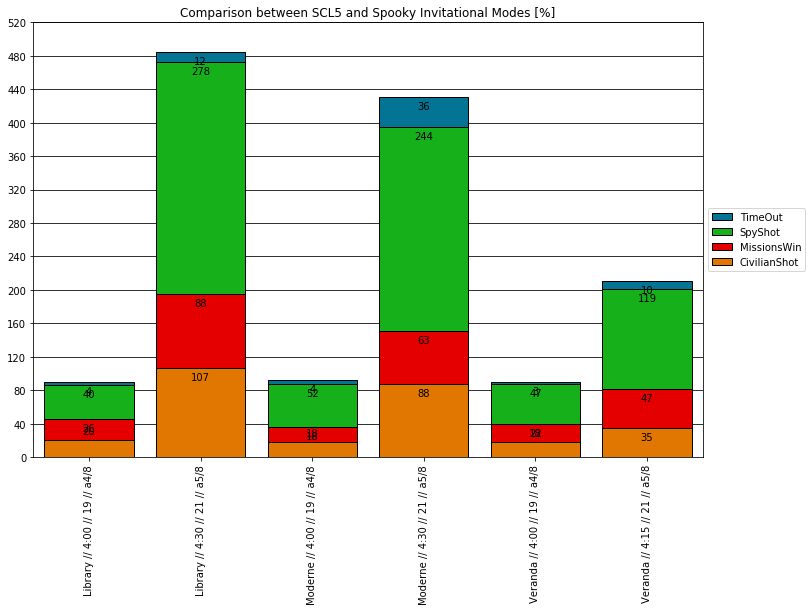

,Library // 4:00 // 19 // a4/8,Library // 4:30 // 21 // a5/8,Moderne // 4:00 // 19 // a4/8,Moderne // 4:30 // 21 // a5/8,Veranda // 4:00 // 19 // a4/8,Veranda // 4:15 // 21 // a5/8
WinType.TimeOut,4,12,4,36,3,10
WinType.SpyShot,40,278,52,244,47,119
WinType.MissionsWin,26,88,18,63,22,47
WinType.CivilianShot,20,107,18,88,18,35


In [11]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: categorize_mode(g),
        #secondary_order=sort_by_spy_wins,
    ),
    axis_properties=AxisProperties(
        title="Comparison between SCL5 and Spooky Invitational Modes [%]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

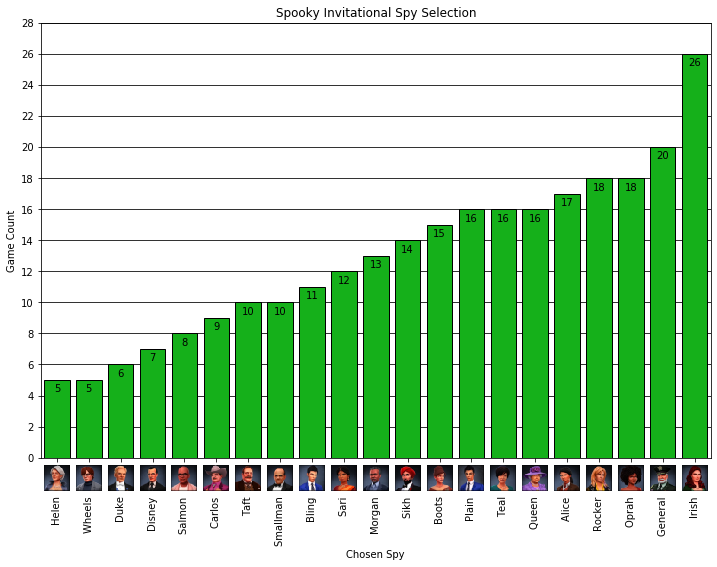

In [12]:
_ = spy_selection(
    spooky_replays,
    axis_properties = AxisProperties(
        title="Spooky Invitational Spy Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Spy",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

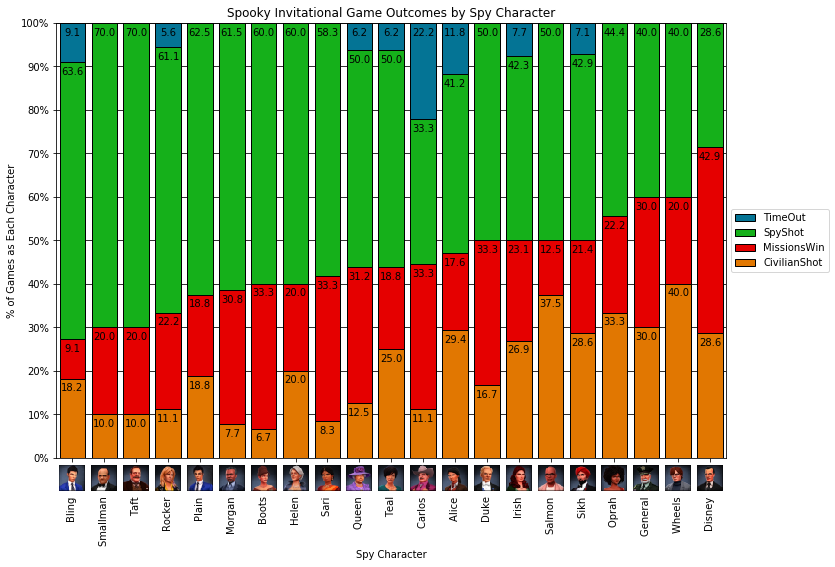

In [13]:
_ = game_outcomes(
    spooky_replays,
    axis_properties = AxisProperties(
        title="Spooky Invitational Game Outcomes by Spy Character",
        x_axis_portrait=True,
        y_axis_label="% of Games as Each Character",
        x_axis_label="Spy Character",
        data_label_style=PlotLabelStyle.Plain,
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: determine_character_in_role(g, Roles.Spy),
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True
    )
)

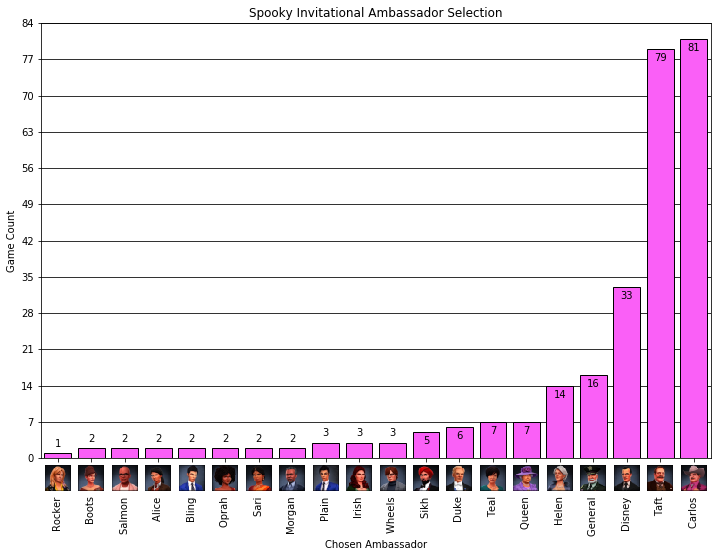

In [14]:
_ = amba_selection(
    spooky_replays,
    axis_properties = AxisProperties(
        title="Spooky Invitational Ambassador Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Ambassador",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

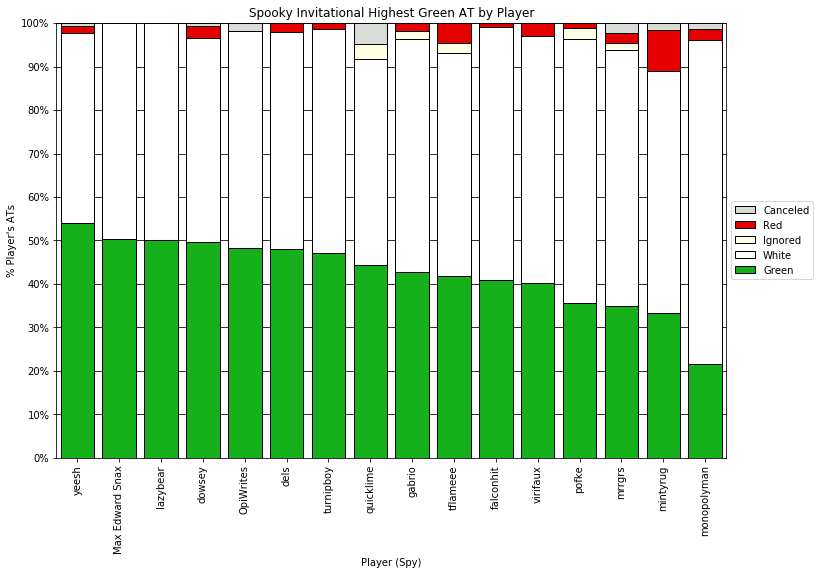

In [15]:
_ = action_test_percentages(
    spooky_replays,
    axis_properties = AxisProperties(
        title='Spooky Invitational Highest Green AT by Player',
        x_axis_label='Player (Spy)',
        y_axis_label='% Player\'s ATs',
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=lambda name_series: -name_series[1][ActionTest.Green],
        limit=30,
        reverse_primary_order=True,
        percent_normalized_data=True)    
)

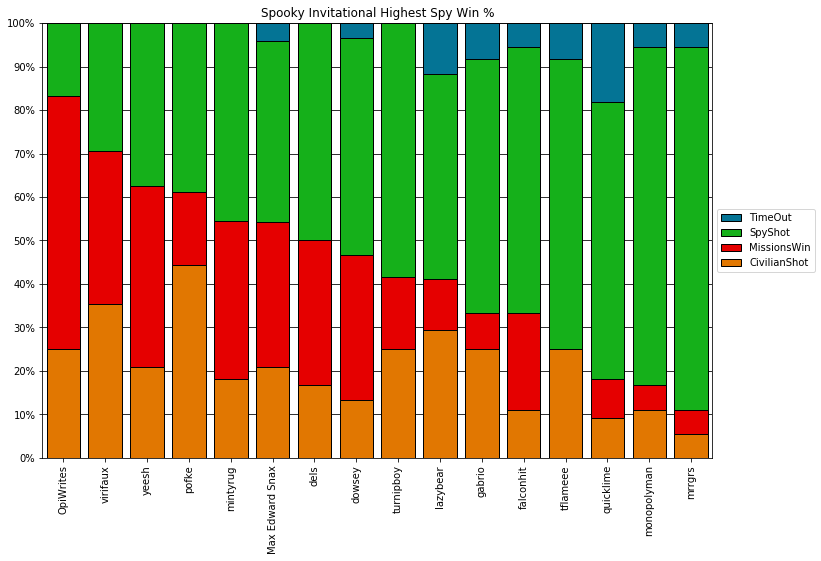

In [16]:
spy_winr = game_outcomes(
    spooky_replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sort_by_spy_wins,
        reverse_secondary_order=True,
        limit=30,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Spooky Invitational Highest Spy Win %")
)

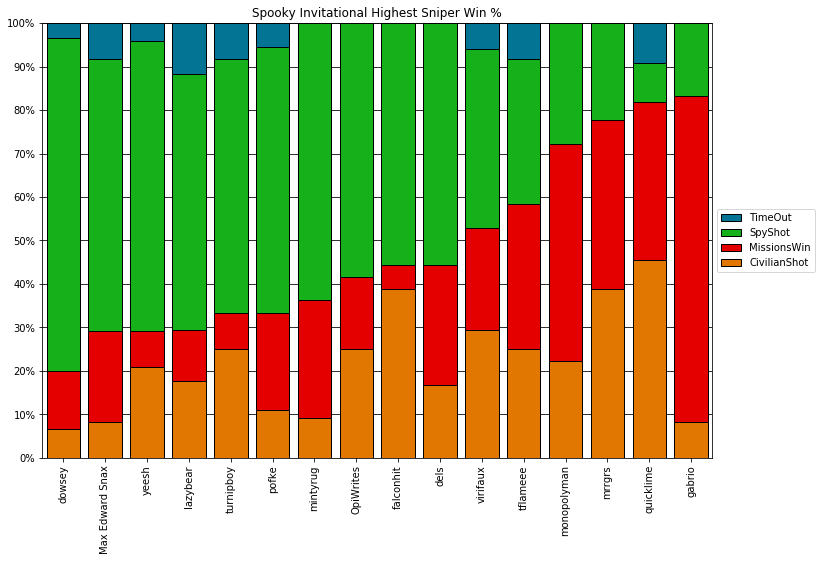

In [17]:
_ = game_outcomes(
    spooky_replays,
    DataQueryProperties(
        groupby=lambda g: g.sniper,
        secondary_order=sort_by_sniper_wins,
        reverse_secondary_order=True,
        limit=30,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Spooky Invitational Highest Sniper Win %")
)

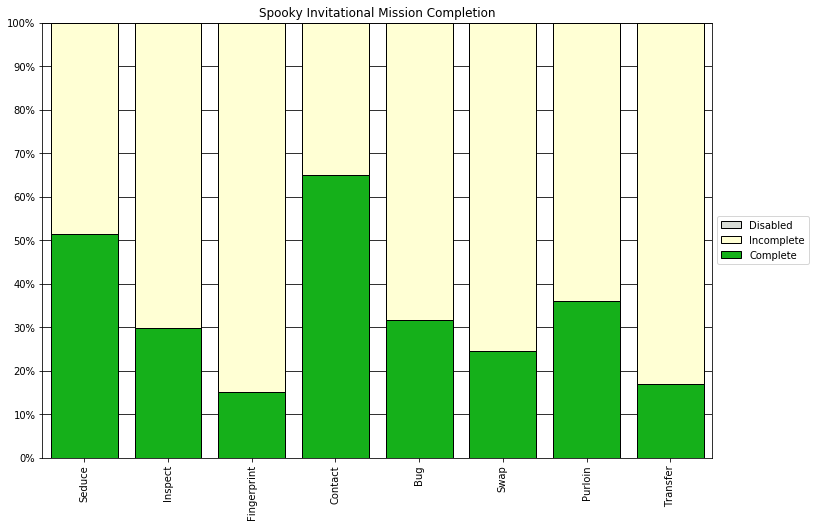

In [18]:
mission_completion(spooky_replays, "Spooky Invitational Mission Completion")